In [1]:
# 训练2天，48小时，画如下几个图：
# 1. loss图2张，每张包含Landlord，LandlordDown，LandlordUP
# 2. ADP和WP图，4张图，每张图是Landlord和Peasants
# 3. Accuracy图，3张，Landlord，LandlordDown，LandlordUP
# 4. WP 对抗SL智能体，ADP对抗SL智能体
# 5. WP对抗DeltaDou智能体，ADP对抗DeltaDou智能体

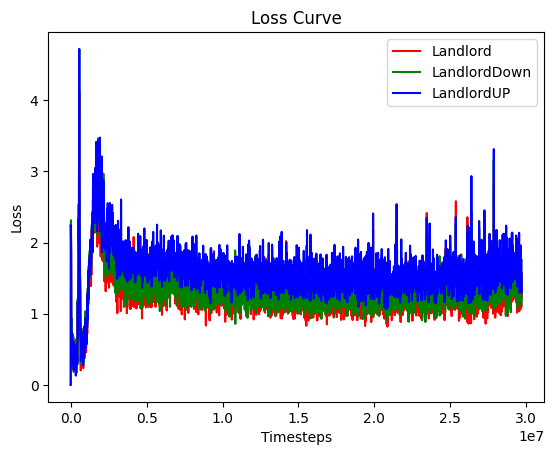

In [1]:
# 1. loss图2张，每张包含Landlord，LandlordDown，LandlordUP
# x轴Timesteps, y轴Loss
# Landlord 红色
# LandlordDown 绿色
# LandlordUP 蓝色

# 从./douzero_checkpoints/douzero/logs.csv读取数据
# logs.csv中的数据有多列，其中frames代表timesteps, loss_landlord, loss_landlord_up, loss_landlord_down为对应的损失
# 将图片按照如下格式保存./image/loss/loss_{frames}_landlord_down_up.png
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件中的数据
logs = pd.read_csv(f'.\image\loss\logs.csv')

# 按照timesteps（frames）排序
logs = logs.sort_values(by=['frames'])

# 绘制Landlord、LandlordDown和LandlordUP的损失曲线
plt.plot(logs['frames'], logs['loss_landlord'], color='red', label='Landlord')
plt.plot(logs['frames'], logs['loss_landlord_down'], color='green', label='LandlordDown')
plt.plot(logs['frames'], logs['loss_landlord_up'], color='blue', label='LandlordUP')

# 设置标题和轴标签
plt.title('Loss Curve')
plt.xlabel('Timesteps')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 保存图片到本地路径./image/loss/
# 检查文件夹是否存在，不存在则创建
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
filename = './image/loss/loss_{}_landlord_down_up.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

# 显示图表
plt.show()

In [2]:
# 2. ADP和WP图，4张图，每张图是Landlord和Peasants

In [3]:
# 3. Accuracy图，3张，Landlord，LandlordDown，LandlordUP


In [4]:
# 4. WP 对抗SL智能体，ADP对抗SL智能体，WP对抗DeltaDou智能体，ADP对抗DeltaDou智能体
